# 00_训练轮数与callbacks
## 拓展

- 可以尝试自己定义学习率衰减规律。使用`LearningRateScheduler`方法，自己定义学习率衰减。

In [5]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 51kB 51.5MB/s eta 0:00:01
     |████████████████████████████████| 317kB 58.0MB/s eta 0:00:01
     |████████████████████████████████| 51kB 63.2MB/s eta 0:00:01
  Found existing installation: Keras-Applications 1.0.2
    Uninstalling Keras-Applications-1.0.2:
      Successfully uninstalled Keras-Applications-1.0.2
  Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Found existing installation: Keras 2.2.0
    Uninstalling Keras-2.2.0:
      Successfully uninstalled Keras-2.2.0


In [6]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()

    session.download_data(
        bucket_path="modelarts-labs/end2end/image_recognition/dog_and_cat_25000.tar.gz",
        path="./dog_and_cat_25000.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./dog_and_cat_25000.tar.gz

    # 清理压缩包
    !rm -f ./dog_and_cat_25000.tar.gz

Successfully download file modelarts-labs/end2end/image_recognition/dog_and_cat_25000.tar.gz from OBS to local ./dog_and_cat_25000.tar.gz


In [2]:
!mkdir model

## 引入相关的包

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import numpy as np

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## 读取数据

In [10]:
import os
from PIL import Image
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [11]:
(x_train, y_train) = load_data()

In [12]:
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


## 数据处理

In [13]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [14]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


## 构建模型

In [3]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [11]:
base_model = VGG16(weights=None, include_top=False)

In [12]:
model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

## 模型训练

In [13]:
import keras 
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 拓展内容：这里将factor改为`0.15`，也就是说每次学习率下降的因子调高，每次学习率调整变为`lr = lr*(0.1 + 0.05)`，使学习率`更和缓`的下降

In [15]:
es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.15, patience=3, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

In [16]:
history = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=10, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 179s 10ms/step - loss: 0.6334 - acc: 0.6792 - val_loss: 0.8516 - val_acc: 0.2813

Epoch 00001: val_acc improved from -inf to 0.28128, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/10
18750/18750 [==============================] - 165s 9ms/step - loss: 0.5714 - acc: 0.7175 - val_loss: 1.1686 - val_acc: 0.2670

Epoch 00002: val_acc did not improve from 0.28128
Epoch 3/10
18750/18750 [==============================] - 164s 9ms/step - loss: 0.5149 - acc: 0.7547 - val_loss: 0.7626 - val_acc: 0.5656

Epoch 00003: val_acc improved from 0.28128 to 0.56560, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 4/10
18750/18750 [==============================] - 164s 9ms/step - loss: 0.4622 - acc: 0.7948 - val_loss: 0.5104 - val_acc: 0.7267

Epoch 00004: val_acc improved from 0.56560 to 0.72672, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 5/10
18750/18750 [===========

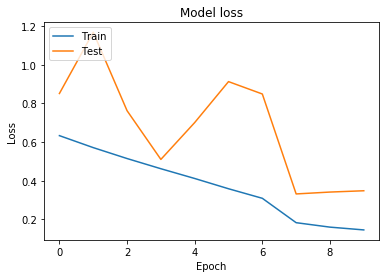

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

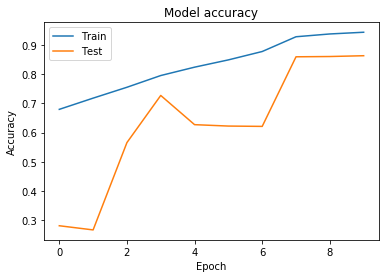

In [20]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 学习率与优化器
在本例中，通过比较**同样结构**，**同样数据集**，**相同训练轮数**下**不同优化器**以及**不同初始学习率**下训练的值得出优化器与初始学习率对训练的影响。

思考
以上的优化器对比都是在训练初期轮数较少的情况下进行，但是在轮数较多或者出现鞍点等情况时，不同的优化器都有不一样的表现。可以尝试用更多的轮数对比不同的优化器，重新审视各个模型在训练各个阶段的表现。

In [39]:
import keras
base_model = VGG16(weights=None, include_top=False)

es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=30, verbose=1, mode='auto')
callbacks = [es]

es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.15, patience=3, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]


# 拓展内容：1.使用`随机梯度算法优化器adam`，初始学习率设置为`0.00005`，epoch设置为`5`
# 2.使用`随机梯度算法优化器adam`，初始学习率设置为`0.00001`，epoch设置为`5`
# 3.使用`优化器SGD`，初始学习率设置为`0.00005`，epoch设置为`5`
# 进行比较

In [40]:
model_adam = build_model(base_model)
opt = keras.optimizers.Adam(lr=0.00005, decay=1e-6)
model_adam.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<class 'keras.engine.training.Model'>


## 注意：这里使用的callback函数和00任务使用的callback函数不一样！不重新设置的话val_acc会一直是零！！！

In [41]:
history_adam = model_adam.fit(x=x_train, 
                y=y_train, 
                batch_size=55, 
                epochs=5, 
                verbose=1, 
                callbacks=callbacks, 
                validation_split=0.25,  
                shuffle=True, 
                initial_epoch=0
                )

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 159s 8ms/step - loss: 0.6295 - acc: 0.6701 - val_loss: 1.0269 - val_acc: 0.1197

Epoch 00001: val_acc improved from -inf to 0.11968, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/5
18750/18750 [==============================] - 158s 8ms/step - loss: 0.5823 - acc: 0.7034 - val_loss: 0.9606 - val_acc: 0.3426

Epoch 00002: val_acc improved from 0.11968 to 0.34256, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 3/5
18750/18750 [==============================] - 158s 8ms/step - loss: 0.5311 - acc: 0.7423 - val_loss: 0.7676 - val_acc: 0.5339

Epoch 00003: val_acc improved from 0.34256 to 0.53392, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 4/5
18750/18750 [==============================] - 158s 8ms/step - loss: 0.4850 - acc: 0.7706 - val_loss: 0.9167 - val_acc: 0.4426

Epoch 00004: val_acc did not improve from 0.53392
Epoch 5/5
18750/18750 [=================

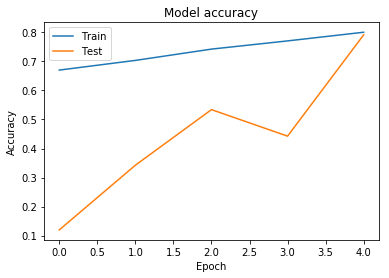

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# 绘制训练 & 验证的准确率值
plt.plot(history_adam.history['acc'])
plt.plot(history_adam.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

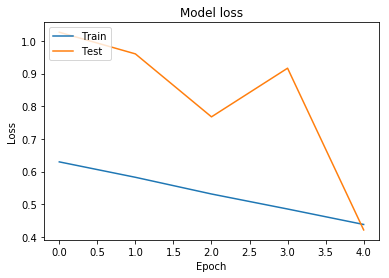

In [43]:
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [46]:
model_adam = build_model(base_model)
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)
model_adam.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<class 'keras.engine.training.Model'>


## 这里训练出的模型val_acc高达`100%`，acc却只有`33%`,很疑惑是否还是属于欠拟合

In [47]:
history_adam = model_adam.fit(x=x_train, 
                y=y_train, 
                batch_size=55, 
                epochs=5, 
                verbose=1, 
                callbacks=callbacks, 
                validation_split=0.25,  
                shuffle=True, 
                initial_epoch=0
                )

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 160s 9ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00001: val_acc improved from 0.79136 to 1.00000, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/5
18750/18750 [==============================] - 158s 8ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/5
18750/18750 [==============================] - 161s 9ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/5
18750/18750 [==============================] - 159s 9ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-06.
Epoch 5/5
18750/18750 [====================

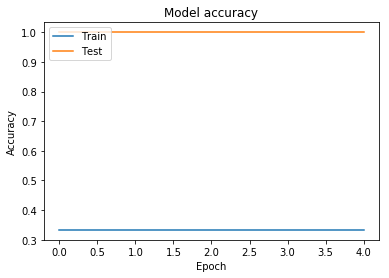

In [48]:
# 绘制训练 & 验证的准确率值
plt.plot(history_adam.history['acc'])
plt.plot(history_adam.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

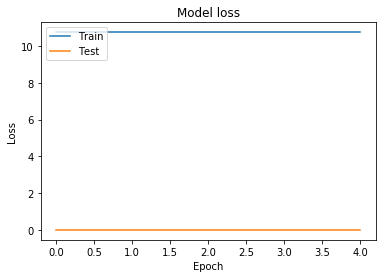

In [49]:
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [52]:
model_sgd = build_model(base_model)
opt = keras.optimizers.SGD(lr=0.00005, decay=1e-6)
model_sgd.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

<class 'keras.engine.training.Model'>


In [53]:
history_sgd = model_sgd.fit(x=x_train, 
                y=y_train, 
                batch_size=55, 
                epochs=5, 
                verbose=1, 
                callbacks=callbacks, 
                validation_split=0.25,  
                shuffle=True, 
                initial_epoch=0
                )

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 156s 8ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00001: val_acc did not improve from 1.00000
Epoch 2/5
18750/18750 [==============================] - 155s 8ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/5
18750/18750 [==============================] - 155s 8ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/5
18750/18750 [==============================] - 154s 8ms/step - loss: 10.7454 - acc: 0.3333 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-06.
Epoch 5/5
18750/18750 [==============================] - 155s 8ms/step - loss: 10.7454 - acc: 0.33

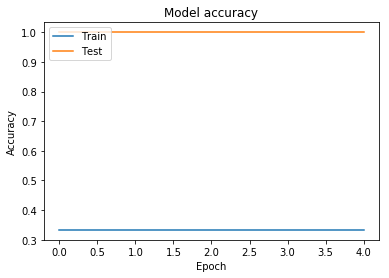

In [54]:
# 绘制训练 & 验证的准确率值
plt.plot(history_sgd.history['acc'])
plt.plot(history_sgd.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

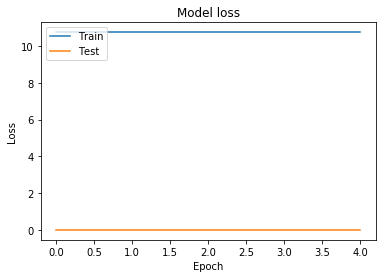

In [55]:
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 数据增广(Data Augumentation)
在VGG论文中，作者提到了数据增广(Data Augumentation)的重要性。在原论文中，作者主要对输入数据的尺寸进行了调整，使用了原始尺寸、较大尺寸和较小尺寸三种规格，并获得了一定的准确率的提升(具体请参考论文或VGG模型解析文章)。在Keras中，我们通过DataGenerator，对输入的图片进行更丰富的预处理，包括缩放、旋转、平移、水平翻转等，来探索数据增广对模型精度带来的提升。预处理并不会直接增加数据集的样本数量，而是让样本具备更加丰富的特征，理论上，可以让训练的模型获得更好的泛化性。

### 扩展

- 尝试调整ImageDataGenerator中的其他参数，并进行组合，查看不同的增广方法对模型训练带来的影响。

- 尝试使用较少的图片做数据集，并加入数据增广进行对比。

In [3]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()

    session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz


In [4]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

ROWS = 224
COLS = 224

if os.path.exists('./data-for-gen') == False:
    !mkdir -p data-for-gen/train/dog
    !mkdir -p data-for-gen/train/cat
    !mkdir -p data-for-gen/val/dog    
    !mkdir -p data-for-gen/val/cat

    DATA_DIR = './data-for-gen/' # 数据集路径
    dog_glob = glob('./data/dog*.jpg')
    cat_glob = glob('./data/cat*.jpg')

    # 我们使用25%的数据作为验证集：
    val_split = 0.25


    index = int(len(dog_glob) * val_split)

    def gen_lnk_cmds(class_name, class_glob):
        cmds = ''
        for i in range(len(class_glob)):
            filename = os.path.basename(class_glob[i])

            src_path = os.path.realpath(class_glob[i])
            sample_type = 'train' if i > index else 'val'
            lnk_path = os.path.realpath('./data-for-gen/{}/{}/{}'.format(sample_type, class_name, filename))
            cmds = cmds + 'ln -s {} {}\n'.format(src_path, lnk_path)

        return cmds

    # 准备dog图片
    print('prepare dog images for data augumentation')
    with open('./tmp_gen_dogs.sh', 'w') as f:
        link_cmds = gen_lnk_cmds('dog', dog_glob)
        f.write(link_cmds)
        !sh ./tmp_gen_dogs.sh
        !rm ./tmp_gen_dogs.sh

    # 准备cat图片
    print('prepare cat images for data augumentation')
    with open('./tmp_gen_cats.sh', 'w') as f:
        link_cmds = gen_lnk_cmds('cat', cat_glob)
        f.write(link_cmds)
        !sh ./tmp_gen_cats.sh
        !rm ./tmp_gen_cats.sh

prepare dog images for data augumentation
prepare cat images for data augumentation


### 拓展内容：旋转角度从原本案例的`10`调整到`20`，宽度和高度偏移范围从`0.2`调整到`0.25`，图片裁剪范围和缩放范围从`0.1`调整到`0.2`，其他参数不变

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

train_datagen = temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,  # ImageDataGenerator使用[0-1]表示RGB色值，加入rescale以正常显示图片
    rotation_range=20, # 旋转角度范围，以角度为单位
    width_shift_range=0.25, # 宽度的偏移范围
    height_shift_range=0.25, # 高度的偏移范围
    shear_range=0.2, # 图片裁剪范围
    zoom_range=0.2, # 图片缩放范围
    fill_mode='nearest', # 图片处理后的填充模式
    horizontal_flip=True) # 是否随机水平翻转图片

val_datagen = temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)

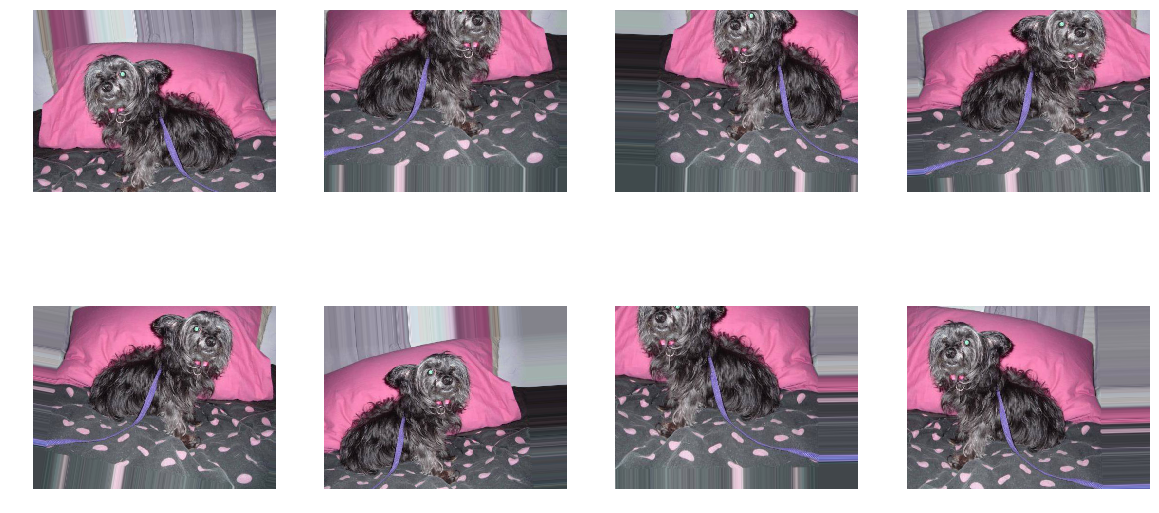

In [6]:
temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)

from PIL import Image
sample_img = Image.open(glob('./data/dog*.jpg')[0])
sample_img = np.expand_dims(sample_img, axis=0)

i = 0
plt.figure(figsize=(20, 10))
for batch in temp_val_datagen.flow(sample_img):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(np.squeeze(batch))
    
    i += 1
    if i >= 8:
        break

plt.show()

In [7]:
train_generator = train_datagen.flow_from_directory('./data-for-gen/train', 
                                                    target_size=(ROWS, COLS), batch_size=16, class_mode='binary')

val_generator = val_datagen.flow_from_directory('./data-for-gen/val', 
                                                target_size=(ROWS, COLS), batch_size=16, class_mode='binary')

Found 18748 images belonging to 2 classes.
Found 6252 images belonging to 2 classes.


In [8]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=1e-4, decay=1e-6) # 优化器使用RMSprop, 设置学习率是1e-4
objective = 'binary_crossentropy' # loss 函数使用交叉熵

base_model = VGG16(weights=None, include_top=False, input_shape=(COLS, ROWS, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(input=base_model.input, output=output)
model.summary()

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [ ]:
epochs = 100 # 训练轮数

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')   
mcp = ModelCheckpoint('aug.weights.{epoch:03d}_{acc:.4f}_{val_acc:.4f}.h5', 
                      monitor='val_acc', save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_lr=1e-9, verbose=1)
# 开始训练
hist = model.fit_generator(
    epochs=epochs,
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    shuffle=True,
    callbacks=[early_stopping, mcp, reduce_lr])

Epoch 1/100
1172/1172 [==============================] - 348s 297ms/step - loss: 0.6783 - acc: 0.5734 - val_loss: 0.6357 - val_acc: 0.6332

Epoch 00001: val_acc improved from -inf to 0.63324, saving model to aug.weights.001_0.5734_0.6332.h5
Epoch 2/100
1172/1172 [==============================] - 338s 288ms/step - loss: 0.6424 - acc: 0.6392 - val_loss: 0.6151 - val_acc: 0.6575

Epoch 00002: val_acc improved from 0.63324 to 0.65755, saving model to aug.weights.002_0.6392_0.6575.h5
Epoch 3/100
1172/1172 [==============================] - 339s 289ms/step - loss: 0.6036 - acc: 0.6802 - val_loss: 0.5379 - val_acc: 0.7369

Epoch 00003: val_acc improved from 0.65755 to 0.73688, saving model to aug.weights.003_0.6802_0.7369.h5
Epoch 4/100
1172/1172 [==============================] - 338s 288ms/step - loss: 0.5848 - acc: 0.7025 - val_loss: 0.5288 - val_acc: 0.7490

Epoch 00004: val_acc improved from 0.73688 to 0.74904, saving model to aug.weights.004_0.7025_0.7490.h5
Epoch 5/100
1172/1172 [====

In [ ]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## 拓展内容：使用`猫狗200数据集`进行`增广`，对比效果

In [3]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()

    session.download_data(
        bucket_path="ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/",
        path="./")

    # 使用tar命令解压资源包
    #!tar xf ./dog_and_cat_25000.tar.gz

    # 清理压缩包
    #!rm -f ./dog_and_cat_25000.tar.gz

Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.0.jpg from OBS to local ./dog_and_cat_200/cat.0.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.1.jpg from OBS to local ./dog_and_cat_200/cat.1.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.10.jpg from OBS to local ./dog_and_cat_200/cat.10.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.11.jpg from OBS to local ./dog_and_cat_200/cat.11.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.12.jpg from OBS to local ./dog_and_cat_200/cat.12.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.13.jpg from OBS to local ./dog_and_cat_200/cat.13.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.14.jpg from OBS to local ./dog_and_c

Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.64.jpg from OBS to local ./dog_and_cat_200/cat.64.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.65.jpg from OBS to local ./dog_and_cat_200/cat.65.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.66.jpg from OBS to local ./dog_and_cat_200/cat.66.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.67.jpg from OBS to local ./dog_and_cat_200/cat.67.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.68.jpg from OBS to local ./dog_and_cat_200/cat.68.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.69.jpg from OBS to local ./dog_and_cat_200/cat.69.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/cat.7.jpg from OBS to local ./dog_an

Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.3.jpg from OBS to local ./dog_and_cat_200/dog.3.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.30.jpg from OBS to local ./dog_and_cat_200/dog.30.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.31.jpg from OBS to local ./dog_and_cat_200/dog.31.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.32.jpg from OBS to local ./dog_and_cat_200/dog.32.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.33.jpg from OBS to local ./dog_and_cat_200/dog.33.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.34.jpg from OBS to local ./dog_and_cat_200/dog.34.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.35.jpg from OBS to local ./dog_and

Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.89.jpg from OBS to local ./dog_and_cat_200/dog.89.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.9.jpg from OBS to local ./dog_and_cat_200/dog.9.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.90.jpg from OBS to local ./dog_and_cat_200/dog.90.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.91.jpg from OBS to local ./dog_and_cat_200/dog.91.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.92.jpg from OBS to local ./dog_and_cat_200/dog.92.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.93.jpg from OBS to local ./dog_and_cat_200/dog.93.jpg
Successfully download file ai-course-bochuan007/dog_and_cat_recognition/dog_and_cat_200/dog.94.jpg from OBS to local ./dog_and

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

ROWS = 224
COLS = 224

if os.path.exists('./data-for-gen') == False:
    !mkdir -p data-for-gen/train/dog
    !mkdir -p data-for-gen/train/cat
    !mkdir -p data-for-gen/val/dog    
    !mkdir -p data-for-gen/val/cat

    DATA_DIR = './data-for-gen/' # 数据集路径
    dog_glob = glob('./dog_and_cat_200/dog*.jpg')
    cat_glob = glob('./dog_and_cat_200/cat*.jpg')

    # 我们使用25%的数据作为验证集：
    val_split = 0.25


    index = int(len(dog_glob) * val_split)

    def gen_lnk_cmds(class_name, class_glob):
        cmds = ''
        for i in range(len(class_glob)):
            filename = os.path.basename(class_glob[i])

            src_path = os.path.realpath(class_glob[i])
            sample_type = 'train' if i > index else 'val'
            lnk_path = os.path.realpath('./data-for-gen/{}/{}/{}'.format(sample_type, class_name, filename))
            cmds = cmds + 'ln -s {} {}\n'.format(src_path, lnk_path)

        return cmds

    # 准备dog图片
    print('prepare dog images for data augumentation')
    with open('./tmp_gen_dogs.sh', 'w') as f:
        link_cmds = gen_lnk_cmds('dog', dog_glob)
        f.write(link_cmds)
        !sh ./tmp_gen_dogs.sh
        !rm ./tmp_gen_dogs.sh

    # 准备cat图片
    print('prepare cat images for data augumentation')
    with open('./tmp_gen_cats.sh', 'w') as f:
        link_cmds = gen_lnk_cmds('cat', cat_glob)
        f.write(link_cmds)
        !sh ./tmp_gen_cats.sh
        !rm ./tmp_gen_cats.sh

prepare dog images for data augumentation
prepare cat images for data augumentation


In [5]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=1e-4, decay=1e-6) # 优化器使用RMSprop, 设置学习率是1e-4
objective = 'binary_crossentropy' # loss 函数使用交叉熵

base_model = VGG16(weights=None, include_top=False, input_shape=(COLS, ROWS, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(input=base_model.input, output=output)
model.summary()

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/ma-user/anaconda3/envs/TensorFlow-1.8/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


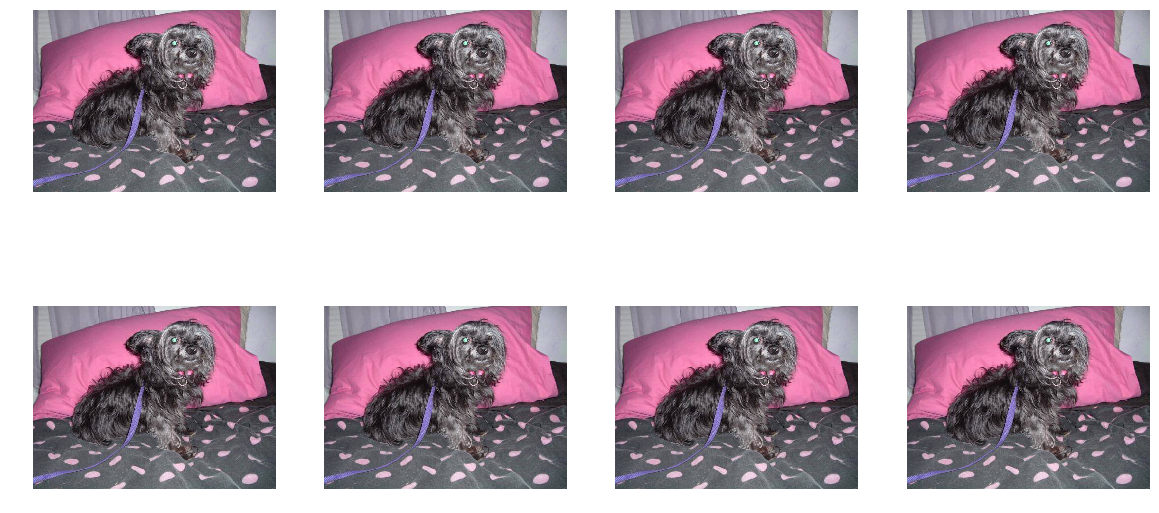

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

train_datagen = temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,  # ImageDataGenerator使用[0-1]表示RGB色值，加入rescale以正常显示图片
    rotation_range=0, # 旋转角度范围，以角度为单位
    width_shift_range=0, # 宽度的偏移范围
    height_shift_range=0, # 高度的偏移范围
    shear_range=0, # 图片裁剪范围
    zoom_range=0, # 图片缩放范围
    fill_mode='nearest', # 图片处理后的填充模式
    horizontal_flip=False) # 是否随机水平翻转图片

val_datagen = temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode='nearest',
    horizontal_flip=False)

temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode='nearest',
    horizontal_flip=False)

from PIL import Image
sample_img = Image.open(glob('./dog_and_cat_200/dog*.jpg')[0])
sample_img = np.expand_dims(sample_img, axis=0)

i = 0
plt.figure(figsize=(20, 10))
for batch in temp_val_datagen.flow(sample_img):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(np.squeeze(batch))
    
    i += 1
    if i >= 8:
        break

plt.show()

In [9]:
train_generator = train_datagen.flow_from_directory('./data-for-gen/train', 
                                                    target_size=(ROWS, COLS), batch_size=16, class_mode='binary')

val_generator = val_datagen.flow_from_directory('./data-for-gen/val', 
                                                target_size=(ROWS, COLS), batch_size=16, class_mode='binary')

Found 148 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [12]:
epochs = 100 # 训练轮数

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')   
mcp = ModelCheckpoint('aug.weights.{epoch:03d}_{acc:.4f}_{val_acc:.4f}.h5', 
                      monitor='val_acc', save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_lr=1e-9, verbose=1)
# 开始训练
hist = model.fit_generator(
    epochs=epochs,
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    shuffle=True,
    callbacks=[early_stopping, mcp, reduce_lr])

Epoch 1/100
10/10 [==============================] - 2s 153ms/step - loss: 0.6005 - acc: 0.6052 - val_loss: 0.7043 - val_acc: 0.5385

Epoch 00001: val_acc improved from -inf to 0.53846, saving model to aug.weights.001_0.5946_0.5385.h5
Epoch 2/100
10/10 [==============================] - 2s 156ms/step - loss: 0.6035 - acc: 0.5737 - val_loss: 0.7086 - val_acc: 0.5385

Epoch 00002: val_acc did not improve from 0.53846
Epoch 3/100
10/10 [==============================] - 1s 146ms/step - loss: 0.5915 - acc: 0.6430 - val_loss: 0.7098 - val_acc: 0.5385

Epoch 00003: val_acc did not improve from 0.53846
Epoch 4/100
10/10 [==============================] - 2s 157ms/step - loss: 0.5934 - acc: 0.6411 - val_loss: 0.7117 - val_acc: 0.5385

Epoch 00004: val_acc did not improve from 0.53846
Epoch 5/100
10/10 [==============================] - 2s 156ms/step - loss: 0.6004 - acc: 0.5881 - val_loss: 0.7110 - val_acc: 0.5385

Epoch 00005: val_acc did not improve from 0.53846
Epoch 6/100
10/10 [==========

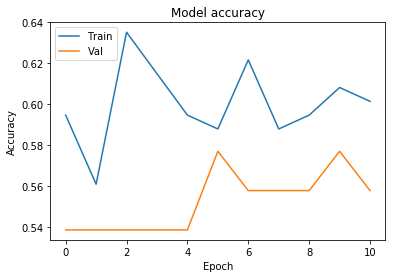

In [13]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

train_datagen = temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,  # ImageDataGenerator使用[0-1]表示RGB色值，加入rescale以正常显示图片
    rotation_range=20, # 旋转角度范围，以角度为单位
    width_shift_range=0.25, # 宽度的偏移范围
    height_shift_range=0.25, # 高度的偏移范围
    shear_range=0.2, # 图片裁剪范围
    zoom_range=0.2, # 图片缩放范围
    fill_mode='nearest', # 图片处理后的填充模式
    horizontal_flip=True) # 是否随机水平翻转图片

val_datagen = temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)

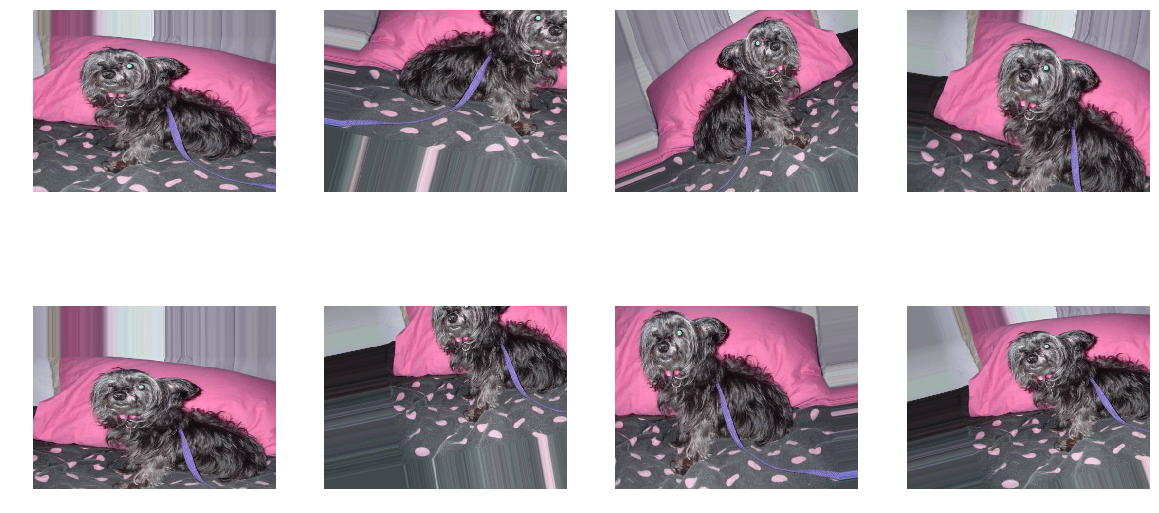

In [15]:
temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)

from PIL import Image
sample_img = Image.open(glob('./dog_and_cat_200/dog*.jpg')[0])
sample_img = np.expand_dims(sample_img, axis=0)

i = 0
plt.figure(figsize=(20, 10))
for batch in temp_val_datagen.flow(sample_img):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(np.squeeze(batch))
    
    i += 1
    if i >= 8:
        break

plt.show()

In [16]:
train_generator = train_datagen.flow_from_directory('./data-for-gen/train', 
                                                    target_size=(ROWS, COLS), batch_size=16, class_mode='binary')

val_generator = val_datagen.flow_from_directory('./data-for-gen/val', 
                                                target_size=(ROWS, COLS), batch_size=16, class_mode='binary')

Found 148 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [18]:
epochs = 100 # 训练轮数

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')   
mcp = ModelCheckpoint('aug.weights.{epoch:03d}_{acc:.4f}_{val_acc:.4f}.h5', 
                      monitor='val_acc', save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_lr=1e-9, verbose=1)
# 开始训练
hist = model.fit_generator(
    epochs=epochs,
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    shuffle=True,
    callbacks=[early_stopping, mcp, reduce_lr])

Epoch 1/100
10/10 [==============================] - 3s 298ms/step - loss: 0.5722 - acc: 0.6663 - val_loss: 0.7058 - val_acc: 0.5577

Epoch 00001: val_acc improved from -inf to 0.55769, saving model to aug.weights.001_0.6419_0.5577.h5
Epoch 2/100
10/10 [==============================] - 2s 211ms/step - loss: 0.5982 - acc: 0.6133 - val_loss: 0.7122 - val_acc: 0.5577

Epoch 00002: val_acc did not improve from 0.55769
Epoch 3/100
10/10 [==============================] - 2s 212ms/step - loss: 0.5944 - acc: 0.6537 - val_loss: 0.7195 - val_acc: 0.5385

Epoch 00003: val_acc did not improve from 0.55769
Epoch 4/100
10/10 [==============================] - 2s 211ms/step - loss: 0.5900 - acc: 0.6978 - val_loss: 0.7014 - val_acc: 0.5962

Epoch 00004: val_acc improved from 0.55769 to 0.59615, saving model to aug.weights.004_0.6757_0.5962.h5
Epoch 5/100
10/10 [==============================] - 2s 207ms/step - loss: 0.5753 - acc: 0.6852 - val_loss: 0.7260 - val_acc: 0.5385

Epoch 00005: val_acc did 

### val_acc最大值相比未做增广的57.69%提升到了65.38%

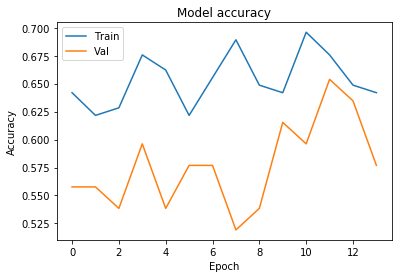

In [19]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## 使用ImageNet预训练模型权重

Keras框架提供了预置好的VGG16模型，并提供使用ImageNet进行大规模训练的权重。我们使用预置的VGG16模型，加载预训练的权重，保留VGG16的卷积网络结构，只在最后的全连接层进行调整，使用GlobalAveragePooling2D将7x7x512的卷积结果进行全局池化，减少训练参数，并加入softmax激活、output shape为2的全连接层进行二分类。

### 扩展

尝试使用更深层的网络，如VGG19, ResNet在ImageNet数据集预训练的权重，并针对猫狗二分类任务进行迁移学习，查看模型训练的效果。

In [3]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()

    session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz


In [4]:
import os
from PIL import Image
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [5]:
(x_train, y_train) = load_data()
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


In [6]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [7]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [8]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


In [9]:
import keras
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

### 扩展内容

### 使用更深层的网络`VGG19`在`ImageNet数据集`预训练的权重，并针对猫狗二分类任务进行`迁移学习`，查看模型训练的效果。

In [10]:
from keras.applications.vgg19 import VGG19
base_model = VGG19(weights='imagenet', include_top=False)
model = build_model(base_model)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

80142336/80134624 [==============================] - 344s 4us/step
<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=15, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./ckpt_vgg19_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=10, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

### 使用vgg19神经网络，最好成绩到达- loss: 0.0778 - acc: 0.9793 - val_loss: 0.0200 - val_acc: 0.9958
### 当acc到达99%的时候，我却发现了几个还不错的val_acc，意外收获
### 思考：单纯以val_acc作为判断是否更新模型的标准似乎不太妥当，感觉应该以 acc * 训练集所占比例 + val_acc * 验证集所占比例 为标准更新模型更为恰当，或者还有前辈高人选择的更好的标准？有空百度下

In [14]:
history = model.fit(x=x_train, 
                    y=y_train, 
                    batch_size=55, 
                    epochs=50, 
                    verbose=1, 
                    callbacks=callbacks, 
                    validation_split=0.25, 
                    shuffle=True, 
                    initial_epoch=0)

Train on 18750 samples, validate on 6250 samples
Epoch 1/50
18750/18750 [==============================] - 184s 10ms/step - loss: 0.0730 - acc: 0.9815 - val_loss: 0.1707 - val_acc: 0.9341

Epoch 00001: val_acc improved from -inf to 0.93408, saving model to ./ckpt_vgg19_dog_and_cat.h5
Epoch 2/50
18750/18750 [==============================] - 184s 10ms/step - loss: 0.0986 - acc: 0.9787 - val_loss: 0.1234 - val_acc: 0.9605

Epoch 00002: val_acc improved from 0.93408 to 0.96048, saving model to ./ckpt_vgg19_dog_and_cat.h5
Epoch 3/50
18750/18750 [==============================] - 184s 10ms/step - loss: 0.0707 - acc: 0.9814 - val_loss: 0.3160 - val_acc: 0.9189

Epoch 00003: val_acc did not improve from 0.96048
Epoch 4/50
18750/18750 [==============================] - 184s 10ms/step - loss: 0.0778 - acc: 0.9793 - val_loss: 0.0200 - val_acc: 0.9958

Epoch 00004: val_acc improved from 0.96048 to 0.99584, saving model to ./ckpt_vgg19_dog_and_cat.h5
Epoch 5/50
18750/18750 [=======================

0.9340799988269806


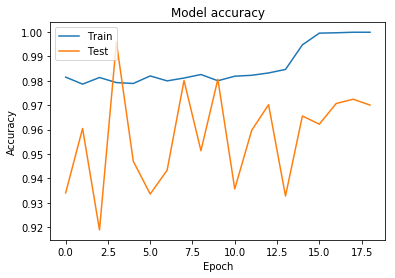

In [16]:
import matplotlib.pyplot as plt
print(history.history['val_acc'][0])

# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

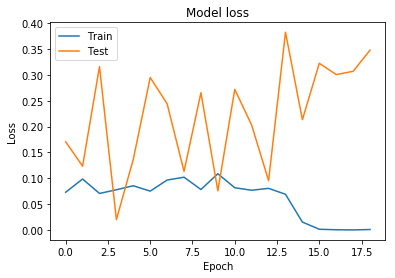

In [17]:
# 绘制训练 & 验证的损失值

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()